# TP DE ICV - Compressor QOI (Quite Okay Image)
### Alunos: Arthur Linhares Madureira - 2021031599, César Morais - 2021031521 e Tomas Lacerda - 2021088116


#### Imports

In [25]:
import struct
from PIL import Image
import os
from math import log10, sqrt 
import cv2 
import numpy as np 
import matplotlib.pyplot as plt


## Compresser

### Expressões
Vamos fazer uso de algumas constantes de opcode caracteristicas e do marcador de final para o QOI

In [9]:
QOI_OP_INDEX = 0x00
QOI_OP_DIFF = 0x40
QOI_OP_LUMA = 0x80
QOI_OP_RUN = 0xC0
QOI_OP_RGB = 0xFE
QOI_OP_RGBA = 0xFF
QOI_END_MARKER = b'\x00' * 8

### Esse algorítimo foi programado seguindo as instruções de https://qoiformat.org

### Algoritmo QOI (Quite Okay Image)

O algoritmo QOI (Quite Okay Image) é um formato de compressão de imagens desenvolvido para rápido e eficiente. Ele é projetado para oferecer uma compressão sem perda de qualidade e é especialmente útil para imagens que contêm muitas áreas de cores repetidas. Este pode ser uma boa alternativa ao uso do método de compressão PNG que vamos comparar com ele ao final do compressor. Por sua vez o QOI possue uma documentação enxuta de apenas 1 página de pdf e se destaca muito por sua simplicidade vide os resultados que atinge. O algorítimo original foi programado em apenas 300 linhas de código na linguagem C e foi publicado no ano de 2022


Aqui está uma explicação da metodologia por trás do algoritmo QOI:

#### Estrutura do Arquivo

Um arquivo QOI é composto por três partes principais:
1. **Cabeçalho**: Contém informações essenciais sobre a imagem.
2. **Dados**: Contém os dados comprimidos da imagem.
3. **Marcador de Fim**: Indica o fim dos dados da imagem.

##### Cabeçalho (14 bytes)
- **Magic Bytes (4 bytes)**: "qoif", usado para identificar o arquivo como um arquivo QOI.
- **Largura (4 bytes)**: A largura da imagem em pixels (big-endian).
- **Altura (4 bytes)**: A altura da imagem em pixels (big-endian).
- **Canais (1 byte)**: Número de canais de cores (3 para RGB, 4 para RGBA).
- **Espaço de Cor (1 byte)**: Indica o espaço de cor (0 para sRGB com alfa linear, 1 para todos os canais lineares).

#### Compressão dos Dados

O QOI utiliza um conjunto de técnicas para comprimir os dados da imagem de maneira eficiente:

1. **Codificação por Índice**:
   - Mantém uma tabela de 64 entradas de cores recentemente vistas.
   - Quando uma cor é encontrada novamente, um índice para essa cor é armazenado em vez dos valores completos dos pixels.

2. **Codificação por Diferença**:
   - Para cores que mudam ligeiramente de um pixel para o próximo, o QOI armazena a diferença entre os valores de cor.
   - Utiliza um único byte para armazenar pequenas diferenças entre as cores.

3. **Codificação Luma**:
   - Extensão da codificação por diferença, otimizada para a diferença no canal de verde (luminância).
   - Armazena a diferença do verde e as diferenças relativas dos canais vermelho e azul em dois bytes.

4. **Codificação de Execução (Run-Length Encoding)**:
   - Agrupa sequências de pixels idênticos.
   - Armazena o número de pixels consecutivos que possuem a mesma cor, utilizando um único byte para representar até 62 pixels iguais.

5. **Codificação Literal (RGB/RGBA)**:
   - Para pixels que não podem ser eficientemente codificados pelos métodos anteriores, os valores RGB ou RGBA são armazenados diretamente.

#### Processamento dos Dados

O algoritmo processa cada pixel da imagem, utilizando as técnicas de compressão descritas para reduzir o tamanho dos dados armazenados. Durante a decompressão, o processo é invertido, reconstruindo a imagem original a partir dos dados comprimidos.

#### Marcador de Fim (8 bytes)
- **Marcador**: Uma sequência de 8 bytes zero, indicando o fim dos dados da imagem.

### Implementação

In [10]:
import struct
from PIL import Image

# Constantes
QOI_OP_INDEX = 0x00
QOI_OP_DIFF = 0x40
QOI_OP_LUMA = 0x80
QOI_OP_RUN = 0xC0
QOI_OP_RGB = 0xFE
QOI_OP_RGBA = 0xFF
QOI_END_MARKER = b'\x00' * 8

def qoiEncode(imagePath, outputPath):
    image = Image.open(imagePath)
    pixels = list(image.getdata())
    width, height = image.size
    channels = 4 if image.mode == 'RGBA' else 3
    header = struct.pack('>4sII', b'qoif', width, height)
    header += struct.pack('BB', channels, 0)

    index = [(0, 0, 0, 255)] * 64
    runLength = 0
    previousPixel = (0, 0, 0, 255) if channels == 4 else (0, 0, 0)

    encodedData = bytearray()
    for pixel in pixels:
        if pixel == previousPixel:
            runLength += 1
            if runLength == 62:
                # Codificação de Execução (Run-Length Encoding)
                encodedData.append(QOI_OP_RUN | (runLength - 1))
                runLength = 0
        else:
            if runLength > 0:
                # Codificação de Execução (Run-Length Encoding)
                encodedData.append(QOI_OP_RUN | (runLength - 1))
                runLength = 0

            # Calcular a posição do índice usando a função de hash
            indexPos = (pixel[0] * 3 + pixel[1] * 5 + pixel[2] * 7 + pixel[3] * 11) % 64 if channels == 4 else (pixel[0] * 3 + pixel[1] * 5 + pixel[2] * 7) % 64
            
            if index[indexPos] == pixel:
                # Codificação por Índice
                encodedData.append(QOI_OP_INDEX | indexPos)
            else:
                index[indexPos] = pixel
                r, g, b = pixel[:3]
                if channels == 4:
                    # Codificação Literal (RGBA)
                    a = pixel[3]
                    encodedData.append(QOI_OP_RGBA)
                    encodedData.extend([r, g, b, a])
                else:
                    dr = (r - previousPixel[0]) & 0xFF
                    dg = (g - previousPixel[1]) & 0xFF
                    db = (b - previousPixel[2]) & 0xFF
                    if -2 <= dr < 2 and -2 <= dg < 2 and -2 <= db < 2:
                        # Codificação por Diferença
                        encodedData.append(QOI_OP_DIFF | ((dr + 2) << 4) | ((dg + 2) << 2) | (db + 2))
                    elif -32 <= dg < 32 and -8 <= (dr - dg) < 8 and -8 <= (db - dg) < 8:
                        # Codificação Luma
                        encodedData.append(QOI_OP_LUMA | (dg + 32))
                        encodedData.append(((dr - dg + 8) << 4) | (db - dg + 8))
                    else:
                        # Codificação Literal (RGB)
                        encodedData.append(QOI_OP_RGB)
                        encodedData.extend([r, g, b])
        
        previousPixel = pixel
    
    # Codificar qualquer runLength restante
    if runLength > 0:
        encodedData.append(QOI_OP_RUN | (runLength - 1))

    with open(outputPath, 'wb') as f:
        f.write(header)
        f.write(encodedData)
        f.write(QOI_END_MARKER)

#### Para descomprimir seguimos um processo de engenharia reversa do que foi feito para comprimir

In [11]:
def qoiDecode(inputPath, outputPath):
    with open(inputPath, 'rb') as f:
        header = f.read(14)
        magic, width, height, channels, colorspace = struct.unpack('>4sII', header[:12]) + struct.unpack('BB', header[12:14])
        
        if magic != b'qoif':
            raise ValueError('Invalid QOI file')

        width = int(width)
        height = int(height)
        channels = int(channels)

        pixels = []
        index = [(0, 0, 0, 255)] * 64
        previousPixel = (0, 0, 0, 255) if channels == 4 else (0, 0, 0)
        runLength = 0

        while len(pixels) < width * height:
            if runLength > 0:
                # Decodificação de Execução (Run-Length Decoding)
                runLength -= 1
                pixels.append(previousPixel)
                continue

            byte = f.read(1)
            if byte == b'':
                break

            byte = ord(byte)
            if byte == QOI_OP_RGB:
                # Decodificação Literal (RGB)
                r = ord(f.read(1))
                g = ord(f.read(1))
                b = ord(f.read(1))
                pixel = (r, g, b, previousPixel[3]) if channels == 4 else (r, g, b)
            elif byte == QOI_OP_RGBA:
                # Decodificação Literal (RGBA)
                r = ord(f.read(1))
                g = ord(f.read(1))
                b = ord(f.read(1))
                a = ord(f.read(1))
                pixel = (r, g, b, a)
            elif byte & 0xC0 == QOI_OP_INDEX:
                # Decodificação por Índice
                pixel = index[byte & 0x3F]
            elif byte & 0xC0 == QOI_OP_DIFF:
                # Decodificação por Diferença
                dr = ((byte >> 4) & 0x03) - 2
                dg = ((byte >> 2) & 0x03) - 2
                db = (byte & 0x03) - 2
                r, g, b = previousPixel[:3]
                pixel = ((r + dr) % 256, (g + dg) % 256, (b + db) % 256, previousPixel[3]) if channels == 4 else ((r + dr) % 256, (g + dg) % 256, (b + db) % 256)
            elif byte & 0xC0 == QOI_OP_LUMA:
                # Decodificação Luma
                dg = (byte & 0x3F) - 32
                byte = ord(f.read(1))
                dr = ((byte >> 4) & 0x0F) - 8 + dg
                db = (byte & 0x0F) - 8 + dg
                r, g, b = previousPixel[:3]
                pixel = ((r + dr) % 256, (g + dg) % 256, (b + db) % 256, previousPixel[3]) if channels == 4 else ((r + dr) % 256, (g + dg) % 256, (b + db) % 256)
            elif byte & 0xC0 == QOI_OP_RUN:
                # Decodificação de Execução (Run-Length Decoding)
                runLength = (byte & 0x3F) + 1
                pixels.append(previousPixel)
                runLength -= 1
                continue
            else:
                raise ValueError('Unknown QOI opcode')

            indexPos = (pixel[0] * 3 + pixel[1] * 5 + pixel[2] * 7 + pixel[3] * 11) % 64 if channels == 4 else (pixel[0] * 3 + pixel[1] * 5 + pixel[2] * 7) % 64
            index[indexPos] = pixel
            previousPixel = pixel
            pixels.append(pixel)

        pixels = [(r, g, b, a) for r, g, b, a in pixels] if channels == 4 else [(r, g, b) for r, g, b in pixels]
        image = Image.new('RGBA' if channels == 4 else 'RGB', (width, height))
        image.putdata(pixels)
        image.save(outputPath)

## Comparação de eficiência

Executamos o algoritmo em um conjunto de imagens próprio para testar o QOI, disponibilizado em (COLOCAR LINK). Como o QOI é um método sem perda, esperamos um PSNR igual a 100, o valor máximo possível para [a implementação utilizada](https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/) (teoricamente o PSNR sem perda tende a infinito).

In [17]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 

    # Se mse = 0, não há ruído na imagem
    if(mse == 0):
        return 100
    
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

def getRawPixelDataSize(imagePath):
    with Image.open(imagePath) as img:
        width, height = img.size
        channels = 4 if img.mode == 'RGBA' else 3
        rawSize = width * height * channels
        return rawSize

def getFileSize(filePath):
    return os.path.getsize(filePath)

def compareCompressionEfficiency(imageName, inputPath, qoiPath, outputPath):
    rawSize = getRawPixelDataSize(inputPath)
    qoiSize = getFileSize(qoiPath)
    psnr = PSNR(cv2.imread(inputPath), (cv2.imread(outputPath, 1)))

    comp_ratio = rawSize / qoiSize
    print(f'{imageName} - PSNR: {psnr}, Compression Ratio: {comp_ratio:.2f}')

    return comp_ratio

In [18]:
def process_images(input_dir, qoi_dir, output_dir):
    os.makedirs(qoi_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)

    compression_ratios = []
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.png'):
            input_path = os.path.join(input_dir, filename)
            qoi_filename = filename.replace('.png', '.qoi')
            qoi_path = os.path.join(qoi_dir, qoi_filename)
            output_path = os.path.join(output_dir, filename)

            qoiEncode(input_path, qoi_path)
            qoiDecode(qoi_path, output_path)
            comp_ratio = compareCompressionEfficiency(filename, input_path, qoi_path, output_path)

            compression_ratios.append(comp_ratio)

    return compression_ratios

# Caminhos dos diretórios
input_images_dir = 'input_images'
qoi_files_dir = 'qoi_files'
output_images_dir = 'output_images'

# Executa o processamento, guardando os compression ratios para comparação posterior com PNG
qoi_compression_ratios = process_images(input_images_dir, qoi_files_dir, output_images_dir)

dice.png - PSNR: 100, Compression Ratio: 3.18
testcard_rgba.png - PSNR: 100, Compression Ratio: 7.17
edgecase.png - PSNR: 100, Compression Ratio: 23.22
wikipedia_008.png - PSNR: 100, Compression Ratio: 1.23
qoi_logo.png - PSNR: 100, Compression Ratio: 23.90
kodim23.png - PSNR: 100, Compression Ratio: 1.13
testcard.png - PSNR: 100, Compression Ratio: 7.58


Como previsto, tivemos PSNR de 100 em todas as compressões, ou seja, não há perda, o que é notável ao vermos quaisquer duas imagens antes e pós compressão:

<div style="display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <img src="input_images/kodim23.png" alt="Image 1" style="width:600px;">
        <p>Imagem antes da compressão</p>
    </div>
    <div style="text-align: center;">
        <img src="output_images/kodim23.png" alt="Image 2" style="width:600px;">
        <p>Imagem após compressão</p>
    </div>
</div>

## Comparação com PNG
O PNG é indiscutivelmente o algoritmo sem perda mais utilizado pelo mercado, e nesse contexto o QOI foi desenvolvido para processamento mais rápido que o PNG, com menores taxas de compressão. Vamos então comparar as taxas de compressão de ambos:

In [38]:
def get_png_compression_ratios(png_path):
    png_comp_ratios = []

    for filename in os.listdir(png_path):
        if filename.endswith('.png'):
            file_path = os.path.join(png_path, filename)
            rawSize = getRawPixelDataSize(file_path)
            pngSize = getFileSize(file_path)

            png_comp_ratios.append(rawSize/pngSize)

    return png_comp_ratios

def plot_bar_graph(labels, qoi_group, png_group):
    x = np.arange(len(labels))
    width = 0.35 
    fig, ax = plt.subplots(figsize=(10, 6))

    rects1 = ax.bar(x - width/2, qoi_group, width, label='QOI')
    rects2 = ax.bar(x + width/2, png_group, width, label='PNG')

    ax.set_ylabel('Compression Ratio')
    ax.set_title('QOI vs. PNG Compression')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10)
    ax.legend()

    fig.tight_layout()

    plt.show()

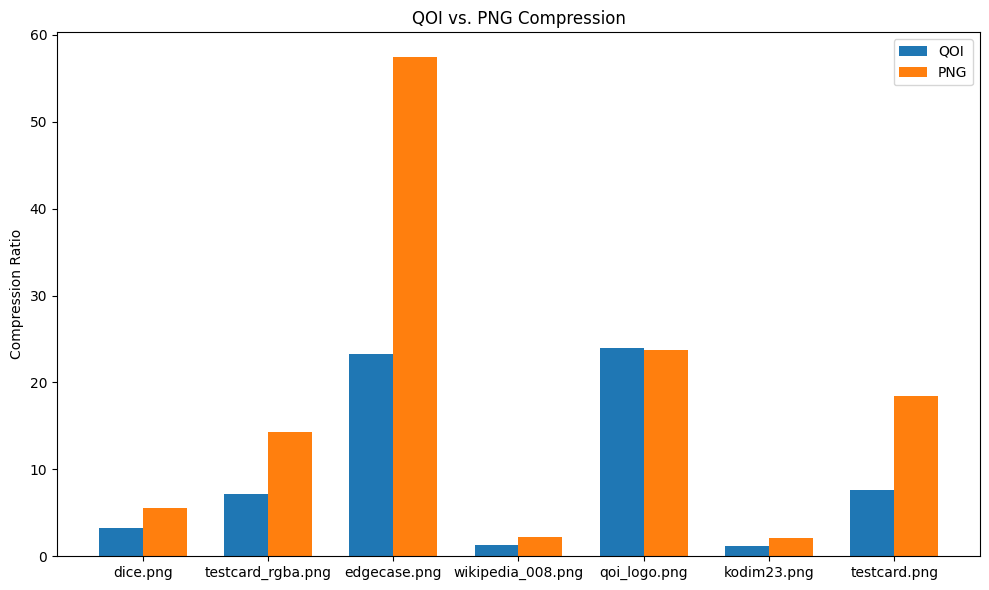

In [39]:
labels = [fn for fn in os.listdir(input_images_dir)]
png_compression_ratios = get_png_compression_ratios(input_images_dir)

plot_bar_graph(labels, qoi_compression_ratios, png_compression_ratios)

É perceptível que, em geral, há resultados piores do que a compressão com PNG, como o esperado.